#  <span style="color:brown"> Выбор локации для скважины

<div style="background-color: white; border: 3px solid black; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

## ОПИСАНИЕ ПРОЕКТА

---

**З А К А З Ч И К:** 

Добывающая компания «ГлавРосГосНефть».

**Ц Е Л Ь:**

Определить наиболее прибыльный регион для бурения новых нефтяных скважин с помощью анализа данных и машинного обучения, минимизируя финансовые риски.

**З А Д А Ч И:**

<span style="color:crimson">

**1.** <span style="color:black">Загрузить и подготовить данные по трём регионам геологоразведки.

**2.** <span style="color:black">Для каждого региона обучить модель линейной регрессии для прогнозирования объёма запасов в скважинах и оценить её качество (RMSE).

**3.** <span style="color:black">Рассчитать минимальный безубыточный объём сырья и сравнить его со средними запасами по регионам.

**4.** <span style="color:black">Написать функцию для расчёта прибыли от разработки 200 лучших скважин, выбранных на основе прогнозов модели.

**5.** <span style="color:black">Применить технику Bootstrap (1000 выборок) для оценки распределения прибыли, рисков убытков (вероятность < 2.5%) и определения региона с максимальной средней прибылью.

**6.** <span style="color:black">Предложить регион для разработки с обоснованием выбора на основе анализа прибыли и рисков.

---

<span style="color:black">**ОПИСАНИЕ ДАННЫХ**

<span style="color:black">Файлы с данными геологоразведки:

- `geo_data_0`
- `geo_data_1`
- `geo_data_2`

<span style="color:black">**СТРУКТУРА ДАННЫХ** (одинаковая для всех трёх регионов):

- `id` <span style="color:black">— уникальный идентификатор скважины;
- `f0, f1, f2` <span style="color:black"> — три значимых признака точек (значения стандартизированы);
- `product` <span style="color:black">— объём запасов в скважине (тыс. баррелей), целевой признак.

<span style="color:black">**УСЛОВИЯ ЗАДАЧИ И КЛЮЧЕВЫЕ ПАРАМЕТРЫ**

- <span style="color:black">**Модель:** Для прогнозирования используется только линейная регрессия.
- <span style="color:black"> **Стратегия разведки:** В регионе исследуют 500 точек, с помощью модели выбирают 200 лучших для разработки.
- <span style="color:black"> **Бюджет:** 10 млрд рублей на разработку скважин в регионе.
- <span style="color:black">**Экономика:** Один баррель сырья приносит 450 рублей дохода. Поскольку объём в данных указан в тысячах баррелей, доход с каждой единицы `product` составляет 450 тыс. рублей.

<span style="color:black">**КРИТЕРИЙ ВЫБОРА РЕГИОНА**

- <span style="color:black">Вероятность убытков (отрицательной прибыли) должна быть менее 2.5%.
- <span style="color:black">Из регионов, удовлетворяющих п.1, выбирается регион с наибольшей средней прибылью.

In [1]:
!pip install phik

In [2]:
# Импорты
import pandas as pd
import os
import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from phik import phik_matrix
from scipy.stats import shapiro, normaltest

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

## ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ

---

<span style="color:crimson">


### Функции

#### Импорт Google-таблицы

In [3]:
def import_google_sheet(spreadsheet_id, sheet_name=None, local_paths=None):
    '''
    Импортируем Google-таблицу в pandas DataFrame с fallback на локальные файлы
    '''
    
    # Сначала пробуем локальные файлы
    if local_paths:
        for path in local_paths:
            if os.path.exists(path):
                print(f'Загружаем из локального файла: {path}')
                return pd.read_csv(path)
    
    # Если локальных файлов нет, грузим из Google Sheets
    if sheet_name:
        url = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    else:
        url = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
    
    print(f"Загружаем из Google Sheets: {url}")
    
    r = requests.get(url)
    r.raise_for_status()
    
    return pd.read_csv(BytesIO(r.content))

#### Общая информация и Первые строки

In [4]:
def head_and_info_display(df, n=5, show_shape=True, show_dtypes=True):
    '''
    Параметры:
    df - DataFrame для анализа
    n - Количество строк
    
    '''
    print('~' * 23)
    print('ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ')
    print('~' * 23)
    
    # 1. Размер данных
    print(f'Форма данных: {df.shape[0]} строк, {df.shape[1]} столбцов')

    # 2. Названия столбцов
    print(f'\nНАЗВАНИЯ СТОЛБЦОВ ({len(df.columns)} шт.):')
    print('-' * 27)
    for i, col in enumerate(df.columns, 1):
       print(f"{i:2}. {col}")
    
    # 3. Первые n строк
    print(f'\nПервые {n} строк:')
    print('-' * 15)
    display(df.head(n))
    
    # 4. Общая информация
    print(f'\nОбщая информация:')
    print('-' * 17)
    df.info()
    
    # 5. Пропущенные значения
    print(f'\nПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:')
    print('-' * 21)
    
    # Вычисляем количество и процент пропусков по столбцам
    missing_values = df.isnull().sum()
    total_rows = df.shape[0]
    
    # Фильтруем только столбцы с пропусками
    columns_with_missing = missing_values[missing_values > 0]
    
    if len(columns_with_missing) == 0:
        print('• Пропущенных значений нет')
    else:
        print(f'• Столбцы с пропущенными значениями ({len(columns_with_missing)} из {df.shape[1]}):')
        
        # Создаем DataFrame для красивого отображения
        missing_df = pd.DataFrame({
                                    'Столбец': columns_with_missing.index,
                                    'Кол-во пропусков': columns_with_missing.values,
                                    '% пропусков': (columns_with_missing.values / total_rows * 100).round(2)
                                 })
        display(missing_df)
        
        print(f'Всего пропусков в датафрейме: {missing_values.sum()}')
        print(f'Средний % пропусков: {(missing_values.sum() / (total_rows * df.shape[1]) * 100).round(2)}%')
       
    # 6. Дубликаты строк
    print(f'\nПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:')
    print('-' * 25)
    duplicates_count = df.duplicated().sum()
    if duplicates_count == 0:
        print('• Дубликатов строк нет')
    else:
        print(f'Найдено {duplicates_count} дубликатов строк ({duplicates_count/total_rows*100:.2f}% данных)') 

#### Визуализация распределения признаков

In [5]:
def plot_distributions_with_stats(df):
    '''Гистограммы, боксплоты + сводная таблица статистики'''
    from scipy.stats import normaltest
    
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    stats_list = []
    
    for col in numeric_cols:
        # Графики
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        
        # Гистограмма
        ax1.hist(df[col], bins=25, color='#2c3e50', edgecolor='#ecf0f1', alpha=0.9)
        median_val = df[col].median()
        mean_val = df[col].mean()
        ax1.axvline(median_val, color='#e74c3c', linestyle='--', linewidth=1.5, label=f'Медиана: {median_val:.2f}')
        ax1.axvline(mean_val, color='#2ecc71', linewidth=1, alpha=0.7)
        
        # Боксплот
        boxplot = ax2.boxplot(df[col].dropna(), vert=False, patch_artist=True, showmeans=True, widths=0.5)
        boxplot['boxes'][0].set(facecolor='#34495e', alpha=0.9)
        boxplot['medians'][0].set(color='#e74c3c', linewidth=1.5)
        boxplot['means'][0].set(marker='o', markeredgecolor='#2ecc71', markerfacecolor='#2ecc71', markersize=6)
        
        # Оформление
        ax1.set_title(f'{col} - г и с т о г р а м м а', fontsize=10, fontweight='bold', pad=8)
        ax2.set_title(f'{col} - б о к с п л о т', fontsize=10, fontweight='bold', pad=8)
        ax1.set_ylabel('Частота', fontsize=9)
        ax2.set_yticks([])
        ax1.grid(alpha=0.2); ax2.grid(alpha=0.2)
        ax1.legend(fontsize=7)
        
        plt.tight_layout()
        plt.show()
        
        # Статистика
        data = df[col].dropna()
        normality_p = None
        normality_result = 'n < 8'
        
        if len(data) >= 8:
            try:
                _, normality_p = normaltest(data)
                normality_result = ('Соответствует' if normality_p > 0.05 else 'Не соответствует') + ' нормальному'
            except:
                normality_result = 'Ошибка'
        
        stats_list.append({
            'Признак': col,
            'Среднее': df[col].mean(),
            'Медиана': median_val,
            'Стд': df[col].std(),
            'Min': df[col].min(),
            '25%': df[col].quantile(0.25),
            '75%': df[col].quantile(0.75),
            'Max': df[col].max(),
            'p-value': normality_p,
            'Распределение': normality_result 
        })
    
    # Таблица
    print('\n' + '-'*80)
    print('СВОДНАЯ СТАТИСТИКА')
    print('-'*80)
    
    if stats_list:
        stats_df = pd.DataFrame(stats_list)
        
        # Форматирование
        def fmt_pval(p):
            if p is None: return '—'
            if p < 1e-323: return '≈ 0'
            if p < 0.0001: return f'{p:.1e}'
            return f'{p:.4f}'
        
        styled = stats_df.style.format({
            'Среднее': '{:.3f}',  
            'Медиана': '{:.3f}', 
            'Стд': '{:.3f}',
            'Min': '{:.3f}', 
            '25%': '{:.3f}', 
            '75%': '{:.3f}', 
            'Max': '{:.3f}',
            'p-value': fmt_pval
        }).applymap(lambda x: 
            'color: crimson' if 'Не соответствует' in str(x) else
            ('color: black' if 'Соответствует' in str(x) else 'color: gray'),
            subset=['Распределение']
        ).set_properties(**{'text-align': 'center'})
        
        display(styled)

### Изучим таблицы

In [6]:
# Импорт таблиц
data_0 = import_google_sheet(
                              spreadsheet_id='1jEJadXtDUaFRunxV2xT3IN8AJbg9KqRENNZKrmJPdhw',  # ID Google таблицы с geo_data_0
                              local_paths=[
                                           '/data/geo_data_0.csv',  # серверный путь
                                           'C:/projects/data/geo_data_0.csv', # Windows путь
                                           './data/geo_data_0.csv'  # локальный путь
                                          ]
                            )
data_1 = import_google_sheet(
                              spreadsheet_id='1YJTFI3P6_wZ2_vMAMtLJkb7NWY0RP6Nq6T836Fw_ntU',  # ID Google таблицы с geo_data_0
                              local_paths=[
                                           '/data/geo_data_1.csv',  # серверный путь
                                           'C:/projects/data/geo_data_1.csv', # Windows путь
                                           './data/geo_data_1.csv'  # локальный путь
                                          ]
                            )
data_2 = import_google_sheet(
                              spreadsheet_id='1AP160RR96KkWiaO2PrnVNI66CWR3vfasGXHTJFbyt1o',  # ID Google таблицы с geo_data_0
                              local_paths=[
                                           '/data/geo_data_2.csv',  # серверный путь
                                           'C:/projects/data/geo_data_2.csv', # Windows путь
                                           './data/geo_data_2.csv'  # локальный путь
                                          ]
                            )

Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1jEJadXtDUaFRunxV2xT3IN8AJbg9KqRENNZKrmJPdhw/export?format=csv
Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1YJTFI3P6_wZ2_vMAMtLJkb7NWY0RP6Nq6T836Fw_ntU/export?format=csv
Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1AP160RR96KkWiaO2PrnVNI66CWR3vfasGXHTJFbyt1o/export?format=csv


In [7]:
# устанавливаем 'id' как индекс для данных
data_0 = data_0.set_index('id')
data_1 = data_1.set_index('id')
data_2 = data_2.set_index('id')

#### Таблица `data_0`

In [8]:
head_and_info_display(data_0)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 100000 строк, 4 столбцов

НАЗВАНИЯ СТОЛБЦОВ (4 шт.):
---------------------------
 1. f0
 2. f1
 3. f2
 4. product

Первые 5 строк:
---------------


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
---------------------
• Пропущенных значений нет

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
-------------------------
• Дубликатов строк нет


#### Визуализация признаков таблицы `data_0`

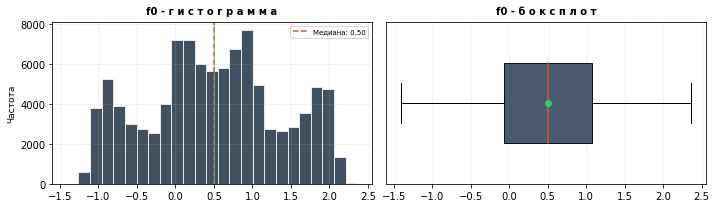

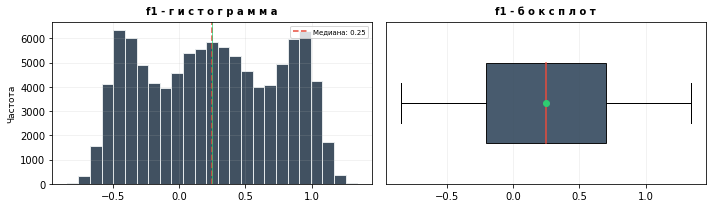

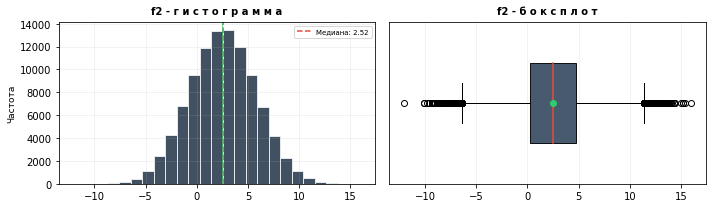

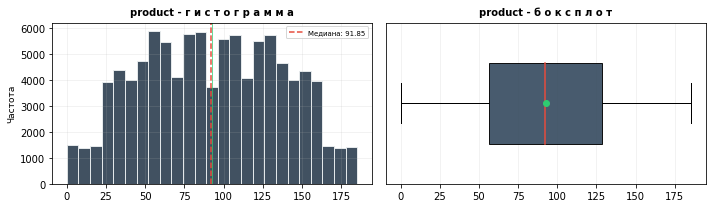


--------------------------------------------------------------------------------
СВОДНАЯ СТАТИСТИКА
--------------------------------------------------------------------------------


,Признак,Среднее,Медиана,Стд,Min,25%,75%,Max,p-value,Распределение
0,f0,0.500,0.502,0.872,-1.409,-0.073,1.074,2.362,≈ 0,Не соответствует нормальному
1,f1,0.250,0.250,0.504,-0.848,-0.201,0.701,1.344,≈ 0,Не соответствует нормальному
2,f2,2.503,2.516,3.248,-12.088,0.288,4.715,16.004,2.6e-13,Не соответствует нормальному
3,product,92.500,91.850,44.289,0.000,56.498,128.564,185.364,≈ 0,Не соответствует нормальному


In [9]:
plot_distributions_with_stats(data_0)

<div style="background-color: white; border: 2px solid brown; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

ОПИСАНИЕ ДАННЫХ ТАЛИЦЫ `data_0`

<span style="color:crimson">
    
--- 
    
- <span style="color:black">Форма данных: 100000 строк, 4 столбцов;
- <span style="color:black">Пропущенных значений нет;
- <span style="color:black">Типы данных верные;
- <span style="color:black">Дубликатов строк нет.

---
    
1. `f0`:
   
- <span style="color:black">Распределение: Не соответствует нормальному `(p ≈ 0)`, но близко к симметричному - `Среднее (0.500) ≈ Медиана (0.502)`;
- <span style="color:black">Стандартное отклонение `(0.872)` - указывает на сильный разброс данных;
- <span style="color:black">Диапазон: `-1.409 до 2.362 (≈3.8 единиц)`. Основная часть значений лежит (50%): `-0.073 до 1.074`.


2. `f1`:

- <span style="color:black"> Не соответствует нормальному `(p ≈ 0)`, но очень близко к симметричному - Необходимо, но недостаточно: `Среднее (0.250) = Медиана (0.250)`;
- <span style="color:black"> Стандартное отклонение `(0.504)` - указывает на сильный разброс данных;
- <span style="color:black"> Диапазон: `-0.848 до 1.344 (≈2.2 единиц)`. Основная часть значений лежит (50%): `-0.201 до 0.701`.

3. `f2`:

- <span style="color:black"> Не соответствует нормальному (`p=2.6e-13`), но близко к симметричному  - Среднее `(0.503)` и Медиана `(0.516)`;
- <span style="color:black"> Стандартное отклонение `(3.248)` - указывает на сильный разброс данных. Также присутствуют выбросы;
- <span style="color:black"> Диапазон: `-12.088 до 16.004 (≈28 единиц)`. Основная часть значений лежит (50%): `4.715 до 16.004`.
  
4. `product` (целевой признак - запасы сырья):

- <span style="color:black"> Не соответствует нормальному `(p ≈ 0)`, близко к симметричному  - `Среднее (92.500 тыс. баррелей) и Медиана (91.850 тыс. баррелей)`;
- <span style="color:black"> Стандартное отклонение (48% от среднего - 44.289) - указывает на сильный разброс данных;
- <span style="color:black"> Диапазон: `0.000 (наличие нулевых значений) до 185.364`. Основная часть значений лежит (50%): `56.498 до 128.564`.

#### Таблица `data_1`

In [10]:
head_and_info_display(data_1)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 100000 строк, 4 столбцов

НАЗВАНИЯ СТОЛБЦОВ (4 шт.):
---------------------------
 1. f0
 2. f1
 3. f2
 4. product

Первые 5 строк:
---------------


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
---------------------
• Пропущенных значений нет

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
-------------------------
• Дубликатов строк нет


#### Визуализация признаков таблицы `data_1`

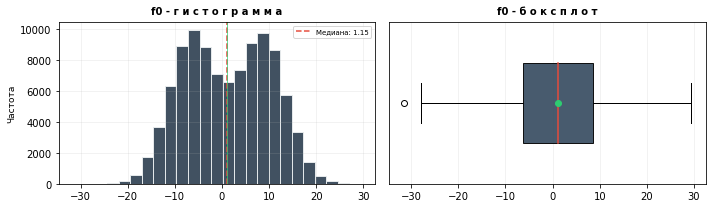

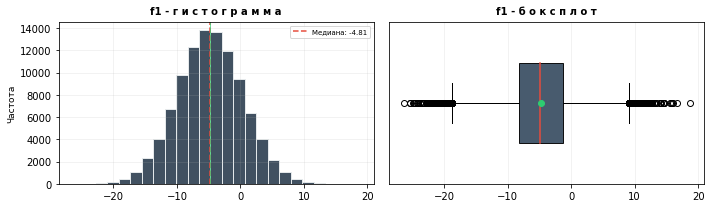

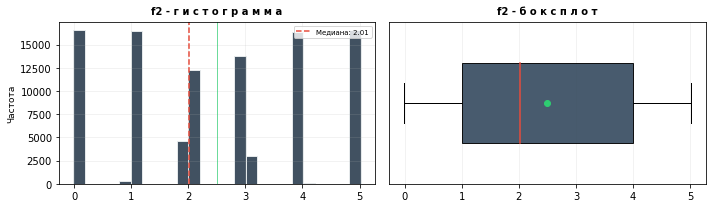

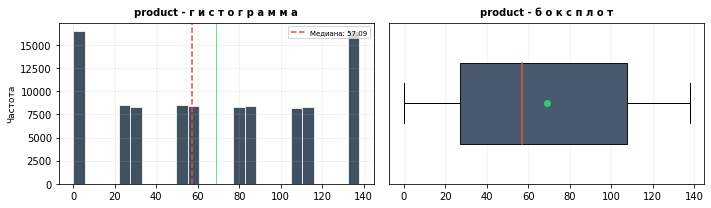


--------------------------------------------------------------------------------
СВОДНАЯ СТАТИСТИКА
--------------------------------------------------------------------------------


,Признак,Среднее,Медиана,Стд,Min,25%,75%,Max,p-value,Распределение
0,f0,1.141,1.153,8.966,-31.610,-6.299,8.621,29.422,≈ 0,Не соответствует нормальному
1,f1,-4.797,-4.813,5.120,-26.359,-8.268,-1.333,18.734,0.0328,Не соответствует нормальному
2,f2,2.495,2.011,1.704,-0.018,1.000,4.000,5.020,≈ 0,Не соответствует нормальному
3,product,68.825,57.086,45.944,0.000,26.953,107.813,137.945,≈ 0,Не соответствует нормальному


In [11]:
plot_distributions_with_stats(data_1)

<div style="background-color: white; border: 2px solid brown; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

ОПИСАНИЕ ДАННЫХ ТАЛИЦЫ `data_1`

<span style="color:crimson">
    
--- 
    
- <span style="color:black">Форма данных: 100000 строк, 4 столбцов;
- <span style="color:black">Пропущенных значений нет;
- <span style="color:black">Типы данных верные;
- <span style="color:black">Дубликатов строк нет.

---
    
1. `f0`:
   
- <span style="color:black">Распределение: Не соответствует нормальному `(p≈0)`, но близко к симметричному - `Среднее (1.141) ≈ Медиана (1.153)`;
- <span style="color:black">Стандартное отклонение `(8.966)` - указывает на сильный разброс данных. Также присутствуют выбросы;
- <span style="color:black">Диапазон: `-31.610 до 29.422 (≈61.032 единиц)`. Основная часть значений лежит (50%): `-6.299 до 8.621`.

2. `f1`:

- <span style="color:black"> Не соответствует нормальному `(p≈0.033)`, но близко к симметричному - Необходимо, но недостаточно: `Среднее (- 4.797) = Медиана (-4.813)`;
- <span style="color:black"> Стандартное отклонение `(5.12)` - указывает на умеренный разброс данных. Также присутствуют выбросы;
- <span style="color:black"> Диапазон: `-26.359 до 18.734 (≈45.1 единиц)`. Основная часть значений лежит (50%): `-8.268 до -1.333`.

3. `f2`:

- <span style="color:black"> Не соответствует нормальному `(p≈0)`, не близко к симметричному  - `Среднее (2.495) и Медиана (2.011)`;
- <span style="color:black"> Стандартное отклонение `(1.704)` - указывает на сильный разброс данных;
- <span style="color:black"> Диапазон: `-0.018 до 5.020 (≈5.04 единиц)`. Основная часть значений лежит (50%): `1 до 4`.
  
4. `product` (целевой признак - запасы сырья):

- <span style="color:black"> Не соответствует нормальному `(p ≈ 0)`, не близко к симметричному  - `Среднее (68.825 тыс. баррелей) и Медиана (57.086 тыс. баррелей)`;
- <span style="color:black"> Стандартное отклонение `(67% от среднего - 45.944)` - указывает на сильный разброс данных;
- <span style="color:black"> Диапазон: `0.000 (наличие нулевых значений) до 137.945`. Основная часть значений лежит (50%): `26.953 до	107.813`.

#### Таблица `data_2`

In [12]:
head_and_info_display(data_2)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 100000 строк, 4 столбцов

НАЗВАНИЯ СТОЛБЦОВ (4 шт.):
---------------------------
 1. f0
 2. f1
 3. f2
 4. product

Первые 5 строк:
---------------


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
---------------------
• Пропущенных значений нет

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
-------------------------
• Дубликатов строк нет


#### Визуализация признаков таблицы `data_2`

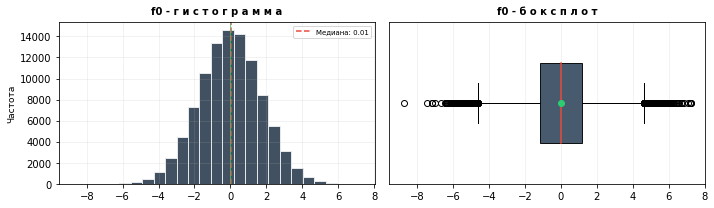

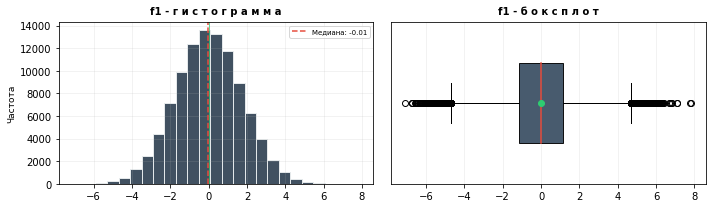

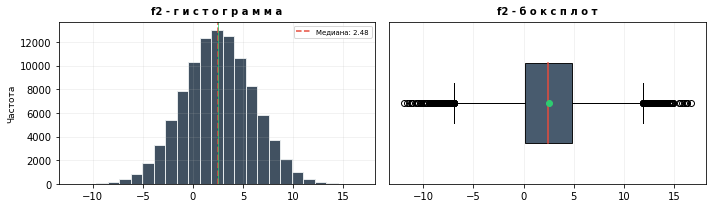

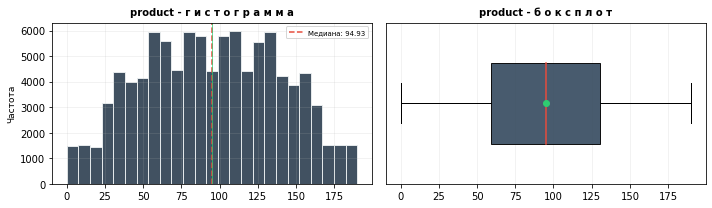


--------------------------------------------------------------------------------
СВОДНАЯ СТАТИСТИКА
--------------------------------------------------------------------------------


,Признак,Среднее,Медиана,Стд,Min,25%,75%,Max,p-value,Распределение
0,f0,0.002,0.009,1.732,-8.760,-1.162,1.159,7.238,0.5371,Соответствует нормальному
1,f1,-0.002,-0.009,1.730,-7.084,-1.175,1.164,7.845,0.1176,Соответствует нормальному
2,f2,2.495,2.484,3.473,-11.970,0.130,4.859,16.739,2.9e-05,Не соответствует нормальному
3,product,95.000,94.926,44.750,0.000,59.450,130.595,190.030,≈ 0,Не соответствует нормальному


In [13]:
plot_distributions_with_stats(data_2)

<div style="background-color: white; border: 2px solid brown; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

ОПИСАНИЕ ДАННЫХ ТАЛИЦЫ `data_2`

<span style="color:crimson">
    
--- 
    
- <span style="color:black">Форма данных: 100000 строк, 4 столбцов;
- <span style="color:black">Пропущенных значений нет;
- <span style="color:black">Типы данных верные;
- <span style="color:black">Дубликатов строк нет.

---
    
1. `f0`:
   
- <span style="color:black">Распределение: соответствует нормальному `(p≈0.54)`, близко к симметричному - `Среднее (0.002) ≈ Медиана (0.009)`;
- <span style="color:black">Стандартное отклонение `(1.73)` - указывает на умеренный разброс данных. Также присутствуют выбросы;
- <span style="color:black">Диапазон: `-8.760 до 7.238 (≈16 единиц)`. Основная часть значений лежит (50%): `-1.162 до 1.159`.


2. `f1`:

- <span style="color:black">Распределение: соответствует нормальному `(p≈0.12)`, но близко к симметричному - `Среднее (- 0.002) и Медиана (-0.009)`;
- <span style="color:black"> Стандартное отклонение `(1.73)` - указывает на умеренный разброс данных. Также присутствуют выбросы;
- <span style="color:black"> Диапазон: `-7.084 до 7.845 (≈14.9 единиц)`. Основная часть значений лежит (50%): `-1.175 до 1.164`.

3. `f2`:

- <span style="color:black"> Не соответствует нормальному `(p=2.9е-05)`, но близко к симметричному  - `Среднее (2.495) и Медиана (2.484)`;
- <span style="color:black"> Стандартное отклонение `(3.473)` - указывает на сильный разброс данных. Также присутствуют выбросы;
- <span style="color:black"> Диапазон: `-11.97 до 16.739 (≈28.7 единиц)`. Основная часть значений лежит (50%): `-0.13 до 4.859`.
  
4. `product` (целевой признак - запасы сырья):

- <span style="color:black"> Не соответствует нормальному `(p ≈ 0)`, не близко к симметричному  - `Среднее (95 тыс. баррелей) и Медиана (94.926 тыс. баррелей)`;
- <span style="color:black"> Стандартное отклонение (47% от среднего - 44.750) - указывает на сильный разброс данных;
- <span style="color:black"> Диапазон: `0.000 (наличие нулевых значений) до 190.030`. Основная часть значений лежит (50%): `59.45 до 130.595`.

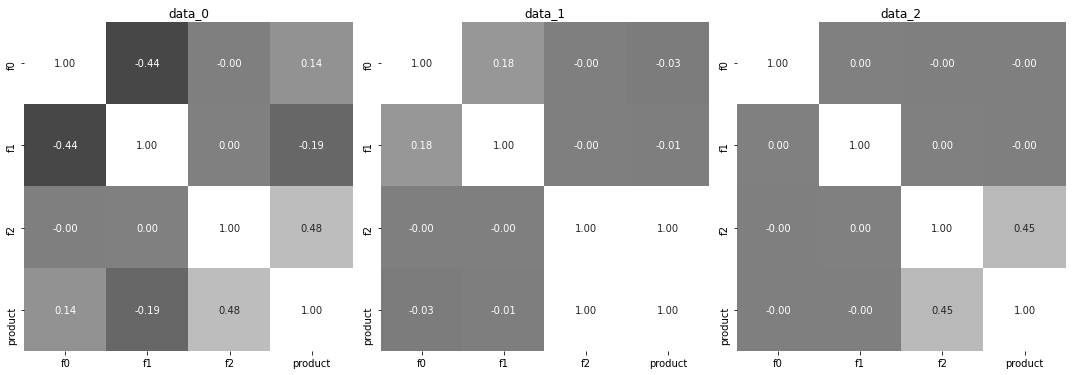

In [14]:
fig = plt.figure(figsize = (15, 5))

# Создаем список данных и названий
data_list = [data_0, data_1, data_2]
name_list = ['data_0', 'data_1', 'data_2']

for i in range(3): 
    ax = fig.add_subplot(1, 3, i+1)
    sns.heatmap(data_list[i].corr(), ax=ax, square=True, annot=True, 
                fmt='.2f', vmax=1, vmin=-1, cbar=False, cmap='gist_gray')
    ax.set_title(name_list[i])

plt.tight_layout()
plt.show()

### Изучим характер связи между признаками

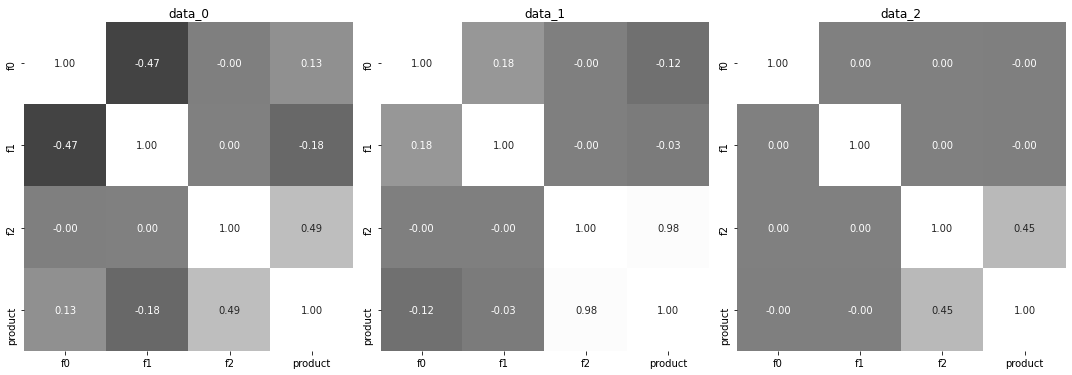

In [15]:
fig = plt.figure(figsize = (15, 5))

# Создаем список данных и названий
data_list = [data_0, data_1, data_2]
name_list = ['data_0', 'data_1', 'data_2']

for i in range(3): 
    ax = fig.add_subplot(1, 3, i+1)
    sns.heatmap(data_list[i].corr(method='spearman'), ax=ax, square=True, annot=True, 
                fmt='.2f', vmax=1, vmin=-1, cbar=False, cmap='gist_gray')
    ax.set_title(name_list[i])

plt.tight_layout()
plt.show()

<div style="background-color: white; border: 1.5px solid black; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

## в ы в о д 

---

<span style="color:crimson">

**1.** <span style="color:black">Анализ трех наборов данных показывает, что все выборки имеют идентичную структуру (100 тыс. строк, 4 столбца) и высокое качество (отсутствие пропусков и дубликатов).

**2.** <span style="color:black">Основные характеристики данных:

- <span style="color:black">Большинство признаков демонстрирует асимметричное распределение с существенным отклонением от нормального закона;
- <span style="color:black">Во всех наборах данных наблюдается значительный разброс значений (высокие стандартные отклонения);
- <span style="color:black">Присутствуют выбросы в большинстве признаков;
- <span style="color:black">Целевой признак (запасы сырья) во всех случаях имеет несимметричное распределение с существенной вариативностью (разброс до 47-67% от среднего значения);
- <span style="color:black">Во всех выборках зафиксированы нулевые значения целевого признака;
- <span style="color:black">Ключевые различия между наборами данных заключаются в характере распределения признаков и диапазоне значений, при этом все три выборки демонстрируют схожую структуру и качество данных.

---

**3.** <span style="color:black">Анализ корреляционных матриц показывает существенные различия в связях между признаками в трёх наборах данных:

`data_0`:

- <span style="color:black">Наблюдается умеренная отрицательная корреляция между `f0` и `f1` (-0.47);
- <span style="color:black">Умеренная положительная связь между `f2` и `product` (0.49);
- <span style="color:black">Остальные связи слабые или практически отсутствуют.

`data_1`:

- <span style="color:black">Выявлена весьма высокая зависимость между `f2` и `product` (0.98) - *потенциальная утечка целевого признака*;
- <span style="color:black">Слабая положительная связь между `f0` и `f1` (0.18);
- <span style="color:black">Остальные корреляции практически нулевые.

`data_2`:

- <span style="color:black">Умеренная положительная связь между `f2` и `product` (0.45);
- <span style="color:black">Остальные связи слабые или практически отсутствуют.
  
<span style="color:black">*Общие выводы по характеру связей признаков в таблицах:*

- <span style="color:black">`f2` во всех наборах данных демонстрирует наибольшую связь с целевым признаком product;
- <span style="color:black">Характер взаимосвязей существенно различается между наборами данных;
- <span style="color:black">В `data_1` наблюдается аномально высокая корреляция между `f2` и `product` - **потенциальная утечка целевого признака**;
- <span style="color:black">В `data_2` связи между признаками практически отсутствуют.

## ОБУЧЕНИЕ И ПРОВЕРКА МОДЕЛИ ДЛЯ КАЖДОГО РЕГИОНА

---

<span style="color:crimson">

- <span style="color:black">2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
- <span style="color:black">2.2. Обучим модель и сделаем предсказания на валидационной выборке.
- <span style="color:black">2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
- <span style="color:black">2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
- <span style="color:black">2.5. Проанализируем результаты.

---

####  Функция. Оценка модели

In [16]:
RANDOM_STATE = 42

In [17]:
def eval_model(data):
    
    '''Оценка модели'''
    
    X = data.drop('product', axis=1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
                                                           X, y, test_size=0.25, random_state=RANDOM_STATE
                                                         )   
    scaler = StandardScaler()
    model = LinearRegression()
    
    model.fit(scaler.fit_transform(X_train), y_train)
    pred = model.predict(scaler.transform(X_valid))
    
    return pred.mean(), np.sqrt(mean_squared_error(y_valid, pred)), X_valid, y_valid, pred

In [18]:
results = []   # Результаты модели
all_data = {}  # Для хранения всех данных

for data, name in zip([data_0, data_1, data_2], ['data_0', 'data_1', 'data_2']):
    # Получаем ВСЕ 5 значений
    mean_pred, rmse, X_valid, y_valid, pred = eval_model(data)
    
    # 1.Сохраняем данные
    all_data[name] = {
                      'X_valid': X_valid,
                      'y_valid': y_valid,
                      'predictions': pred
                     }
    
    # Для удобства создаём переменные
    if name == 'data_0':
        X0_valid, y0_valid, predict0 = X_valid, y_valid, pred
    elif name == 'data_1':
        X1_valid, y1_valid, predict1 = X_valid, y_valid, pred
    elif name == 'data_2':
        X2_valid, y2_valid, predict2 = X_valid, y_valid, pred
    
    # 2.Добавляем метрики в таблицу ()
    results.append([name, mean_pred, rmse])

# Создаём таблицу
df_result = pd.DataFrame(results, columns=['Регион', 'Ср. запас предсказанного сырья', 'RMSE'])

display(df_result)

,Регион,Ср. запас предсказанного сырья,RMSE
0,data_0,92.398800,37.756600
1,data_1,68.712878,0.890280
2,data_2,94.771024,40.145872


In [19]:
# Для data_0
X0_valid = all_data['data_0']['X_valid']
y0_valid = all_data['data_0']['y_valid']
predict0 = all_data['data_0']['predictions']

# Для data_1
X1_valid = all_data['data_1']['X_valid']
y1_valid = all_data['data_1']['y_valid']
predict1 = all_data['data_1']['predictions']

# Для data_2
X2_valid = all_data['data_2']['X_valid']
y2_valid = all_data['data_2']['y_valid']
predict2 = all_data['data_2']['predictions']

<div style="background-color: white; border: 2px solid brown; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

## в ы в о д 

---

<span style="color:crimson">
    
**`data_1`** <span style="color:black">:

- <span style="color:black"> **Наименьший прогноз** среднего запаса предсказанного сырья (68.71);
- <span style="color:black"> **Лучшее качество** модели (RMSE=0.89).

**`data_2`** <span style="color:black">:

- <span style="color:black"> **Наибольший прогноз** среднего запаса предсказанного сырья (94.77);
- <span style="color:black"> **Худшее качество** модели (RMSE=40.15) - высокая неопределённость прогнозов.


**`data_0`** <span style="color:black">:

- <span style="color:black">**Чуть меньше прогноз** среднего запаса предсказанного сырья (92.39), **чем у `data_2`**;
- <span style="color:black">**Чуть лучше качество** модели, **чем `data_2`**, но все равно высокая неопределённость прогнозов (RMSE=37.75).

## ПОДГОТОВКА К РАСЧЁТУ ПРИБЫЛИ


---

<span style="color:crimson">

- <span style="color:black"> 3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.

---

In [20]:
# Глобальные параметры проекта
ALL_POINTS = 500 # В регионе исследуют 500 точек
BEST_POINTS = 200  # Выбирают 200 лучших для разработки
BUDGET = 10 * 10**9  # 10 млрд рублей (10 × 10^9) на разработку скважин в регионе
REVENUE_PER_UNIT = 450 * 1000  # 450 тыс. рублей за 1000 баррелей

---

<span style="color:crimson">

- <span style="color:black">3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

---

In [21]:
# Расчёт на одну скважину
budget_per_well = BUDGET / BEST_POINTS  # Бюджет на 1 скважину
min_volume_per_well = budget_per_well / REVENUE_PER_UNIT  # Минимальный объём для безубыточности

print(f'Бюджет на одну скважину: {budget_per_well:.0f} рублей')
print(f'Минимальный объём для безубыточности: {min_volume_per_well:.1f} тыс. баррелей')

Бюджет на одну скважину: 50000000 рублей
Минимальный объём для безубыточности: 111.1 тыс. баррелей


In [22]:
# Берём значения из df_result
for idx, row in df_result.iterrows():
    name = row['Регион']
    mean_pred = row['Ср. запас предсказанного сырья']
    diff = mean_pred - min_volume_per_well
    print(f"{name}: средний запас {mean_pred:.1f} тыс.барр. ({'выше' if diff > 0 else 'ниже'} безубыточного на {abs(diff):.1f})")

data_0: средний запас 92.4 тыс.барр. (ниже безубыточного на 18.7)
data_1: средний запас 68.7 тыс.барр. (ниже безубыточного на 42.4)
data_2: средний запас 94.8 тыс.барр. (ниже безубыточного на 16.3)


<div style="background-color: white; border: 2px solid brown; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

## в ы в о д 

---

<span style="color:crimson">

- <span style="color:black"> Безубыточный порог составляет `111.1 тыс. баррелей` на скважину. Т.е. проект окупится только если в каждом регионе найдётся хотя бы 200 скважин с реальными запасами больше или равно `111.111 тыс. баррелей`.
- <span style="color:black"> Средние прогнозные запасы во всех трёх регионах `(68.7-94.8 тыс. баррелей)` ниже данного порога, что означает невозможность окупаемости при случайном выборе скважин.
- <span style="color:black"> Для достижения прибыльности необходимо отобрать `200 лучших скважин`, прогнозируемый запас которых превышает порог окупаемости.
- <span style="color:black"> Однако, учитывая ошибку моделей `(RMSE 0.9-40.1 тыс. баррелей)`, реальные запасы отобранных скважин могут оказаться ниже прогнозируемых, что требует оценки рисков через bootstrap-анализ.


## РАСЧЁТ ПРИБЫЛИ И РИСКОВ ДЛЯ КАЖДОГО РЕГИОНА

---

<span style="color:crimson">

- <span style="color:black">4.1. Выберем скважины с максимальными значениями предсказаний.
- <span style="color:black">4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- <span style="color:black">4.3. Рассчитаем прибыль для полученного объёма сырья.

---  

In [23]:
def profit(data, y_true, y_predict):
    data['predict'] = y_predict # Добавляем прогнозы модели
    data['true'] = y_true # Добавляем реальные значения
    data = data.sort_values(by='predict', ascending=False) # Сортируем по прогнозам
    data = data.head(200) # Берём 200 лучших по прогнозу
    profite = data['true'].sum() * REVENUE_PER_UNIT - BUDGET # Считаем прибыль
    return profite

---

<span style="color:crimson">

- <span style="color:black">5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- <span style="color:black">5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
  
---

####  Функция. Применение Bootstrap и расчёт статистистики

In [24]:
def bootstrap_analysis(X_valid, y_valid, predictions, region_name):
    '''
    Bootstrap-анализ для одного региона
    
    Параметры:
    -----------
    X_valid : DataFrame - признаки валидационной выборки
    y_valid : Series - реальные запасы сырья
    predictions : array - предсказания модели
    region_name : str - название региона
    
    На выходе:
    --------
    dict - словарь с результатами
    '''
    # Инициализация
    state = np.random.RandomState(12345)
    profit_values = []
    
    # 1000 bootstrap-итераций
    for i in range(1000):
        # Выборка 500 скважин с возвращением
        subsample = X_valid.sample(n=500, replace=True, random_state=state)
        
        # Создание DataFrame с предсказаниями для правильной индексации
        pred_df = pd.DataFrame(predictions, index=X_valid.index)
        
        # Расчёт прибыли для выборки
        profit_val = profit(subsample, y_valid, pred_df)
        profit_values.append(profit_val)
    
    # Рассчёт статистики
    
    profit_series = pd.Series(profit_values)
    profite_mean = profit_series.mean().round()  # Средняя ожидаемая прибыль
    
    # 95% доверительный интервал
    lower = profit_series.quantile(0.025).round()  # 2.5% перцентиль
    upper = profit_series.quantile(0.975).round()  # 97.5% перцентиль
    confidence_interval = f'от {lower:.0f} до {upper:.0f}'
    
    # Риск убытков
    losses_risks = len([i for i in profit_values if i < 0]) / len(profit_values) * 100

    # Словарь с результатами
    dict = {
            'REGION': region_name,
            'PROFITE_MEAN, руб.': profite_mean,
            'CONFIDENCE_INTERVAL, руб.': confidence_interval,
            'LOSSES_RISKS, %': losses_risks
            }
    
    return dict

In [25]:
# Применяем функцию и создаем DataFrame с конечными результатами для трёх регионов
results_list = []

results_list.append(bootstrap_analysis(X0_valid, y0_valid, predict0, 'data_0'))
results_list.append(bootstrap_analysis(X1_valid, y1_valid, predict1, 'data_1'))
results_list.append(bootstrap_analysis(X2_valid, y2_valid, predict2, 'data_2'))

results = pd.DataFrame(results_list) # Создаем итоговый DataFrame
display(results)

,REGION,"PROFITE_MEAN, руб.","CONFIDENCE_INTERVAL, руб.","LOSSES_RISKS, %"
0,data_0,406278783.0,от -117742136 до 911737051,6.7
1,data_1,432624132.0,от 16846175 до 815972526,1.9
2,data_2,377362192.0,от -170780418 до 901772131,7.4


<div style="background-color: white; border: 2px solid brown; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

## в ы в о д 

<span style="color:crimson">

- <span style="color:black">5.3. Предложим регион для разработки скважин и обоснуем выбор.

---

    
- <span style="color:black"> Средняя ожидаемая прибыль по регионам варьируется `от 377 до 433 млн. рублей`.
- <span style="color:black"> **Наибольшую среднюю прибыль демонстрирует** `data_1 (432.6 млн руб.)`, наименьшую — `data_2 (377.4 млн руб.)`.
- <span style="color:black"> 95% доверительный интервал показывает, как может варьироваться прибыль:

    - `data_1: от +16.8 млн до +816.0 млн руб.` — **самый стабильный интервал**
    - `data_0: от -117.7 млн до +911.7 млн руб.`<span style="color:black"> — широкий разброс
    - `data_2: от -170.8 млн до +901.8 млн руб.` <span style="color:black">— наибольшая неопределённость

- <span style="color:black"> Риск убытков (доля отрицательных значений) составляет:

    - `data_1: 1.9%` — **минимальный риск**
    - `data_0: 6.7%` <span style="color:black">— умеренный риск
    - `data_2: 7.4%` <span style="color:black">— максимальный риск

--- 

<span style="color:black">*Согласно условиям задачи, для разработки подходят только регионы с риском убытков менее 2.5%.*

РЕКОМЕНДОВАННЫЙ РЕГИОН:

<span style="color:black">`data_1` является единственным регионом, удовлетворяющим требованию по минимальному риску `(1.9% < 2.5%)`. При этом он демонстрирует наибольшую среднюю ожидаемую прибыль `(432.6 млн руб.)` среди всех анализируемых регионов.

ОБОСНОВАНИЕ ВЫБОРА:

<span style="color:black">Bootstrap-анализ показал, что `data_1` является оптимальным регионом для разработки 

- <span style="color:black">со средней ожидаемой прибылью `432.6 млн рублей`,
- <span style="color:black">риском убытков `1.9%` (что удовлетворяет критерию < 2.5%)
- <span style="color:black">и 95% доверительным интервалом `от +16.8 до +815.9 млн рублей`.


<span style="color:black">Остальные регионы не соответствуют требованию по минимальному риску.

<div style="background-color: white; border: 3px solid black; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

## ОБЩИЙ ВЫВОД

ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ

- Все три набора данных `(data_0, data_1, data_2)` имеют идентичную структуру и высокое качество.
- Наблюдаются существенные различия в характере распределения признаков между наборами.
- Выявлена аномальная корреляция в `data_1` между `f2` и целевым признаком (потенциальная утечка данных).

ОБУЧЕНИЕ И ПРОВЕРКА МОДЕЛИ ДЛЯ КАЖДОГО РЕГИОНА

- Наилучшее качество модели продемонстрировано в `data_1` (RMSE=0.89).
- Худшие показатели — в `data_2` (RMSE=40.15).
- Прогнозные средние запасы варьируются `от 68.7 до 94.8 тыс. баррелей`.

РАСЧЁТ ПРИБЫЛИ И РИСКОВ ДЛЯ КАЖДОГО РЕГИОНА

- Безубыточный порог составляет `111.1 тыс. баррелей` на скважину.
- Средняя ожидаемая прибыль по регионам: `от 377 до 433 млн. рублей`.
- Наибольший риск убытков наблюдается в `data_2` (7.4%), наименьший — в `data_1` (1.9%).

РЕКОМЕНДАНДАЦИИ ВЫБОРУ РЕГИОНА

- На основании комплексного анализа рекомендуется выбрать регион `data_1` для разработки скважин, так как он:
- Обеспечивает максимальную среднюю прибыль `(432.6 млн руб.)`
- Имеет минимальный риск убытков `(1.9% < 2.5%)`
- Демонстрирует наиболее стабильный прогноз прибыли с доверительным интервалом `от +16.8 до +816.0 млн. руб`.
- Обладает наилучшими показателями качества модели

Таким образом, несмотря на более низкие прогнозные запасы в `data_1`, данный регион является оптимальным выбором с точки зрения баланса между потенциальной прибылью и уровнем риска.